We remember that the way the formula to diagonalize the covariance matrix was via a Fourier transform with the condition
$$
M_{m n}=\frac{1}{N} \sum_{\theta_{k} \in(-\pi, \pi)} \omega\left(\theta_{k}\right) e^{\phi\left(\theta_{k}\right)} e^{i(m-n) \theta_{k}}
$$
with $\omega\left(\theta_{k}\right)=\omega\left(\theta_{k}\right)^{*}=\omega\left(-\theta_{k}\right),\  \phi\left(-\theta_{k}\right)=-\phi\left(\theta_{k}\right)$. So $\Omega$ is real and $\phi$ is skew-symmetric, and are given by
$$
\omega^{2}\left(\theta_{k}\right) :=\left(\lambda-\cos \theta_{k}\right)^{2}+\gamma^{2} \sin ^{2} \theta_{k}
$$

$$
\phi\left(\theta_{k}\right) :=\arctan \left(\frac{-\gamma \sin \theta_{k}}{\lambda-\cos \theta_{k}}\right)
$$
So we define $\alpha(\theta)=\lambda-\cos \theta_{k}$ and $\beta(\theta)=-\gamma \sin \theta_{k}$

In [1]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from ipywidgets import interactive
from scipy.fftpack import fft, ifft,ifftshift,fftshift
from scipy.linalg import circulant
from IPython.display import display, HTML

# -------------------------- To center the output ---------------
#CSS_center = """
#.output {
#    display: flex;
#    align-items: center;
#    text-align: center;
#"""
#CSS_left = """
#.output {
#    display: flex;
#    align-items: left;
#    text-align: left;
#}
#"""
#HTML('<style>{}</style>'.format(CSS_center))
#HTML('<style>{}</style>'.format(CSS_left))
display(HTML("""
<style>
.output {
    display: flex;
    align-items: left;
    text-align: center;
}
</style>
"""))

# ---------------------------------------------------
# Define the parameters of the system
N_size=41 #
Gamma=0.5
Lambda=0.5

# ---------------------------------------------------

def Alpha(Gamma,Lambda,theta):
    return Lambda+np.cos(theta)
def Beta(Gamma,Lambda,theta):
    return -Gamma*np.sin(theta)
def Omega(Gamma,Lambda,theta):
    return np.sqrt(Alpha(Gamma,Lambda,theta)**2 + Beta(Gamma,Lambda,theta)**2 )
def Phi(Gamma,Lambda,theta):
    return np.arctan2(Beta(Gamma,Lambda,theta),Alpha(Gamma,Lambda,theta))

In [ ]:

def Plot_energies(Gamma,Lambda):
    plt.figure(figsize=(13,8))
    x=np.linspace(-np.pi,np.pi,100)
    plt.plot(x,Phi(Gamma,Lambda,x),label=r"$\phi$")
    plt.plot(x,Alpha(Gamma,Lambda,x),label=r"$\alpha$")
    plt.plot(x,Beta(Gamma,Lambda,x),label=r"$\beta$")
    plt.plot(x,Omega(Gamma,Lambda,x),label=r"$\Omega$")
    plt.legend()
    plt.show() 
interactive_plot = interactive(Plot_energies, Gamma=(-2, 2,0.1), Lambda=(-2, 2, 0.1))
output = interactive_plot.children[-1]
output.layout.height = '550px'
interactive_plot

In [2]:
def Fermi_dirac(beta,mu,n,Gamma=Gamma,Lambda=Lambda,N=N_size):
    # beta is the inverse thermic energy associated in the system (beta)
    # mu corresponds to the chemical potential
    # n is the position of the particle
    # f=np.exp(T*(Omega(Gamma,Lambda,2.0*(np.pi/N)*n)-mu)) +1
    # N corresponds to the size of the system
    f=np.exp(beta*(Omega(Gamma,Lambda,((2.*np.pi)/float(N)) * n)-mu)) +1
    return 1/f
def plot_interactive(beta,mu):
    plt.figure(figsize=(10,7))
    n=np.arange(-(N_size-1)/2,(N_size-1)/2+ 1)
    plt.subplot(2,1,1)
    plt.plot(n,Fermi_dirac(beta,mu,n))
    #plt.ylim(-0.05,1.05)
    plt.xlabel("Position")
    plt.ylabel("Probability")
    plt.subplot(2,1,2)
    plt.plot(n,Omega(Gamma,Lambda,(2.*np.pi)/float(N_size)*n),label=r"$\Omega$")
    plt.show()

The value of $\beta$ should be of the order of the GAP so take the minimum value of the energy and take the inverse of it.

In [3]:
interactive_plot = interactive(plot_interactive, beta=(0, 2,0.001), mu=(-2, 2, 0.01))
output = interactive_plot.children[-1]
output.layout.height = '450px'
interactive_plot

interactive(children=(FloatSlider(value=1.0, description='beta', max=2.0, step=0.001), FloatSlider(value=0.0, …

Now we sample the number of occupation number for $\sin$ and $\cos$, but as we have to sample the modes for half the circle and then all for the other half we fix exactly the same number. Such construction has to satisfy.

$$
m_{\cos}[n]=m_{\cos}[-n]\quad  \forall n>0
$$
$$
m_{\sin}[n]=m_{\sin}[-n]\quad  \forall n>0
$$

So first we sample the random numbers for half for the circle and then extend this for the other half. remembering that the right upper part of the covariance matrix can be computed as:


$$
\begin{aligned} \tilde{\Gamma}_{m n} &=\sum_{\theta_{k}}^{\pi}\left[m^{c}\left(\theta_{k}\right) u_{m}^{c}\left(\theta_{k}\right) v_{n}^{c}\left(\theta_{k}\right)+m^{s}\left(\theta_{k}\right) u_{m}^{s}\left(\theta_{k}\right) v_{n}^{s}\left(\theta_{k}\right)\right] \\ &=\sum_{\theta_{k}=-\pi}^{\pi}\left(\frac{m^{c}\left(\theta_{k}\right)+m^{s}\left(\theta_{k}\right)}{2}\right)\left(u_{m}^{c}\left(\theta_{k}\right) v_{n}^{c}\left(\theta_{k}\right)+u_{m}^{s}\left(\theta_{k}\right) v_{n}^{s}\left(\theta_{k}\right)\right) \\ &+\sum_{\theta_{k}=-\pi}^{\pi}\left(\frac{m^{c}\left(\theta_{k}\right)-m^{s}\left(\theta_{k}\right)}{2}\right)\left(u_{m}^{c}\left(\theta_{k}\right) v_{n}^{c}\left(\theta_{k}\right)-u_{m}^{s}\left(\theta_{k}\right) v_{n}^{s}\left(\theta_{k}\right)\right) \end{aligned}
$$


which is basically

$$
\tilde{\Gamma}_{m n}=\overbrace{\sum_{\theta_{k}=-\pi}^{\pi} m^{+}\left(\theta_{k}\right) e^{i \phi\left(\theta_{k}\right)} e^{i(n-m) \theta_{k}}}^{\tilde{\Gamma}_{m n}^{+}}+\underbrace{\sum_{\theta_{k}=-\pi}^{\pi} m^{-}\left(\theta_{k}\right) e^{i \phi\left(\theta_{k}\right)} e^{i(n+m) \theta_{k}}}_{\tilde{\Gamma}_{m n}^{-}}
$$
 the Fourier transform of $
m^{+}\left(\theta_{k}\right) e^{i \phi\left(\theta_{k}\right)}$ y $ m^{-}\left(\theta_{k}\right) e^{i \phi\left(\theta_{k}\right)}$

In [4]:
x=np.arange(0,(N_size-1)/2+ 1)
beta=0.01
mu=2
m_cos=[-0.5 if np.random.random()>Fermi_dirac(beta,mu,i) else 0.5 for i in x]
m_sin=[-0.5 if np.random.random()>Fermi_dirac(beta,mu,i) else 0.5 for i in x]
m_cos=np.array(m_cos[1:][::-1]+m_cos)
m_sin=np.array(m_sin[1:][::-1]+m_sin)
M_plus=(m_cos+m_sin)*0.5
M_minous=(m_cos-m_sin)*0.5

# Up to now we first test if our code is working or not
we test replacing the value of $M^{(+)}$ for the average over the occupation number (i.e 1, and 0 for $M^{(-)}$). we fill the values of the exponential taking into account the parity of the point, so we take the sign of that point and evaluate $\phi$ in the absolute value of the point

In [5]:
M_plus=1
M_minous=0
x=np.arange(-(N_size-1)/2,(N_size-1)/2+1)
Mplusband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
Mplusband=M_plus*np.array(Mplusband)
Mminousband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
Mminousband=M_minous*np.array(Mminousband)

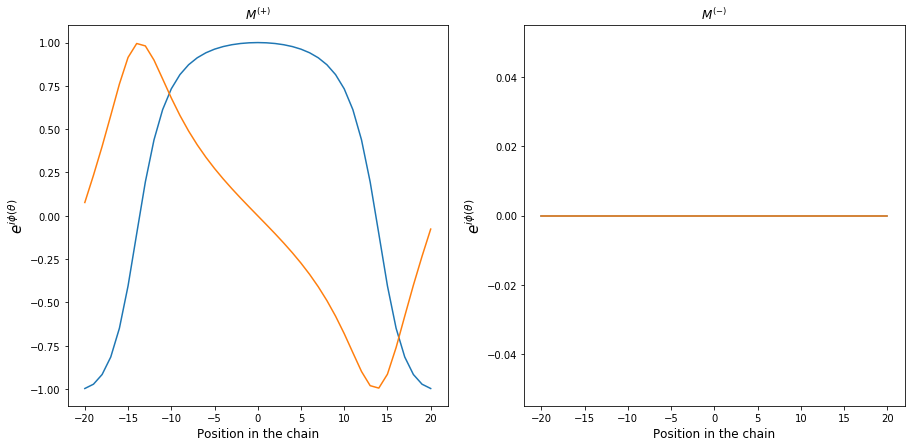

In [6]:
x=np.arange(-(N_size-1)/2,(N_size-1)/2+1)
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.plot(x,Mplusband.real,label="real part")
plt.plot(x,Mplusband.imag,label="imaginary part")
plt.title(r"$M^{(+)}$")
plt.xlabel("Position in the chain",fontsize=12)
plt.ylabel(r"$e^{i\phi(\theta)}$",fontsize=15)
plt.subplot(1,2,2)
plt.plot(x,(Mminousband).real,label="real part")
plt.plot(x,(Mminousband).imag,label="imaginary part")
plt.title(r"$M^{(-)}$")
plt.xlabel("Position in the chain",fontsize=12)
plt.ylabel(r"$e^{i\phi(\theta)}$",fontsize=15)
plt.show()

# Trying with the roll function of numpy

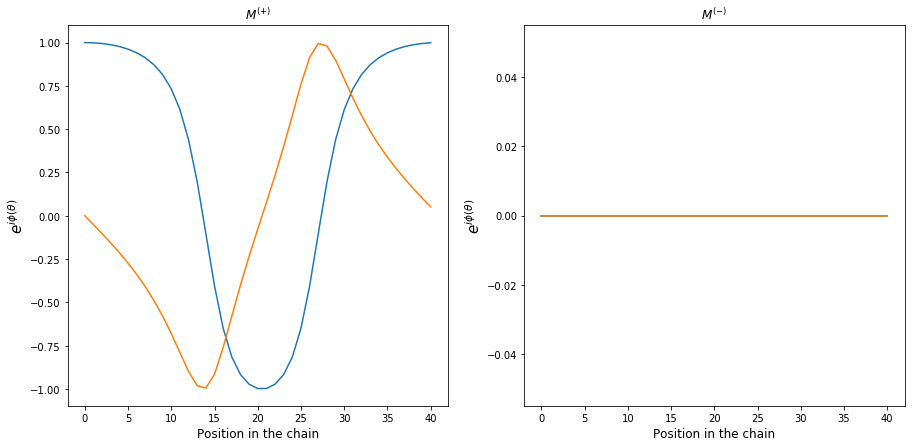

In [7]:
Mminousband_new=np.roll(Mminousband,-(N_size-1)//2)
Mplusband_new=np.roll(Mplusband,-(N_size-1)//2)
x=np.arange(N_size)
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.plot(x,Mplusband_new.real,label="real part")
plt.plot(x,Mplusband_new.imag,label="imaginary part")
plt.title(r"$M^{(+)}$")
plt.legend()
plt.xlabel("Position in the chain",fontsize=12)
plt.ylabel(r"$e^{i\phi(\theta)}$",fontsize=15)
plt.subplot(1,2,2)
plt.plot(x,(Mminousband_new).real,label="real part")
plt.plot(x,(Mminousband_new).imag,label="imaginary part")
plt.title(r"$M^{(-)}$")
plt.xlabel("Position in the chain",fontsize=12)
plt.ylabel(r"$e^{i\phi(\theta)}$",fontsize=15)
plt.legend()
plt.show()

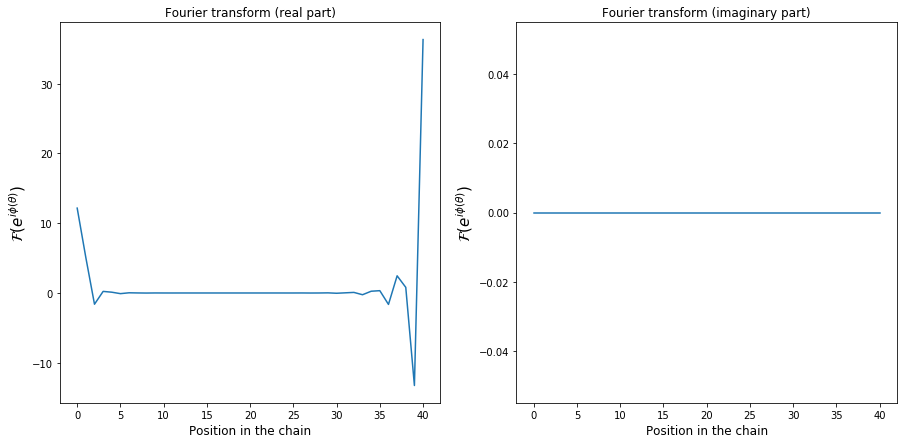

In [12]:
Fourier_transform=fft(Mplusband_new)
x=np.arange(N_size)
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.plot(x,Fourier_transform.real,label="real part")
plt.title(r"Fourier transform (real part)")
plt.xlabel("Position in the chain",fontsize=12)
plt.ylabel(r"$\mathcal{F} (e^{i\phi(\theta)})$",fontsize=15)
plt.subplot(1,2,2)
plt.plot(x,Fourier_transform.imag,label="imaginary part")
plt.xlabel("Position in the chain",fontsize=12)
plt.ylabel(r"$\mathcal{F} (e^{i\phi(\theta)})$",fontsize=15)
plt.title(r"Fourier transform (imaginary part)")
plt.show()

# Transforming again to the original sequence

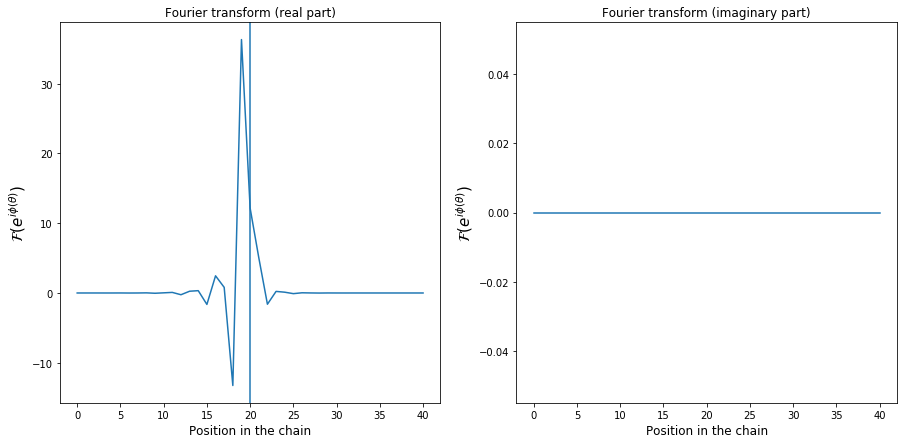

In [49]:
Fourier_transform=np.roll(fft(Mplusband_new),(N_size-1)//2)
x=np.arange(N_size)
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.plot(x,Fourier_transform.real,label="real part")
plt.title(r"Fourier transform (real part)")
plt.xlabel("Position in the chain",fontsize=12)
plt.ylabel(r"$\mathcal{F} (e^{i\phi(\theta)})$",fontsize=15)
plt.axvline(x=20)
plt.subplot(1,2,2)
plt.plot(x,Fourier_transform.imag,label="imaginary part")
plt.xlabel("Position in the chain",fontsize=12)
plt.ylabel(r"$\mathcal{F} (e^{i\phi(\theta)})$",fontsize=15)
plt.title(r"Fourier transform (imaginary part)")
plt.show()

In [51]:
x=np.arange(-(N_size-1)/2,(N_size-1)/2 +1)
new_x=np.roll(x,-(N_size-1)//2)
print(new_x)
np.roll(new_x,(N_size-1)//2)

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20. -20. -19. -18. -17. -16. -15. -14.
 -13. -12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.]


array([-20., -19., -18., -17., -16., -15., -14., -13., -12., -11., -10.,
        -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
         2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,
        13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.])

# Testing with fftshift of scipy for Fourier transforms

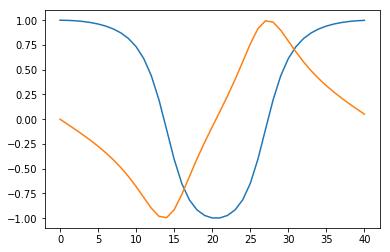

In [23]:
plt.plot(ifftshift(Mplusband).real)
plt.plot(ifftshift(Mplusband).imag)

In [52]:
print(x)
print("Inverse fftshift:",ifftshift(x))
print("fftshift:",fftshift(x))

print("fftshift of ifftshift:",fftshift(ifftshift(x)))

[-20. -19. -18. -17. -16. -15. -14. -13. -12. -11. -10.  -9.  -8.  -7.
  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.   4.   5.   6.   7.
   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.  20.]
Inverse fftshift: [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20. -20. -19. -18. -17. -16. -15. -14.
 -13. -12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.]
fftshift: [  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20. -20. -19. -18. -17. -16. -15. -14. -13.
 -12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.]
fftshift of ifftshift: [-20. -19. -18. -17. -16. -15. -14. -13. -12. -11. -10.  -9.  -8.  -7.
  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.   4.   5.   6.   7.
   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.  20.]


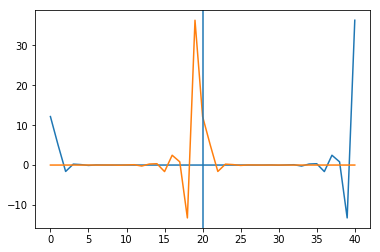

In [53]:
Fourier_Transform_fft=fft(ifftshift(Mplusband))
Fourier_Transform_ifft=fftshift(fft(ifftshift(Mplusband)))
plt.plot(Fourier_Transform_fft.real)
plt.plot(Fourier_Transform_ifft.real)
plt.axvline(x=20)

In [14]:
x[np.argmin(fft(ifftshift(Mplusband_new)))]

20.0

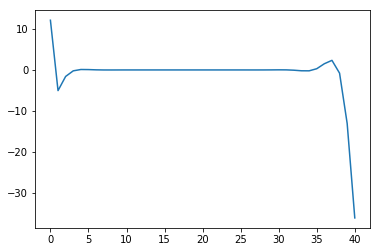

In [15]:
plt.plot(fft(fftshift(Mplusband_new)))

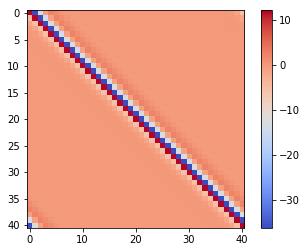

In [16]:
plt.imshow(circulant(fft(fftshift(Mplusband_new))).real,cmap="coolwarm")
plt.colorbar()

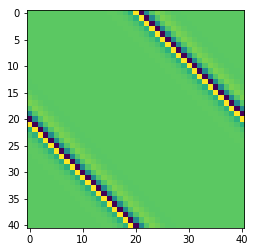

In [17]:
plt.imshow(circulant(ifftshift(fft(fftshift(Mplusband_new))).real))

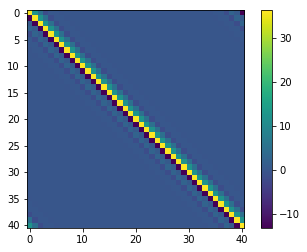

In [18]:
plt.imshow(circulant(fft(Mplusband_new)[::-1].real))
plt.colorbar()

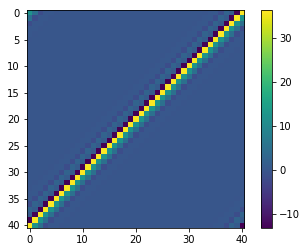

In [19]:
plt.imshow(circulant(fft(Mplusband_new)[::-1].real)[::-1])
plt.colorbar()

In [20]:
circulant(fft(Mplusband_new)[::-1]).max()

(36.320652953236795+0j)

In [21]:
from scipy.linalg import circulant

In [22]:
circulant([1,2,2,])

array([[1, 2, 2],
       [2, 1, 2],
       [2, 2, 1]])

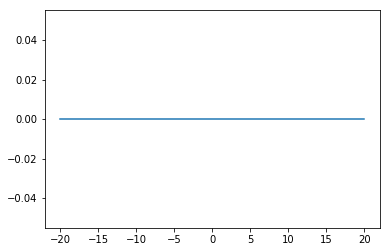

In [23]:
x=np.arange(-(N_size-1)/2,(N_size-1)/2+1)
plt.plot(x,fft(Mminousband_new).real)

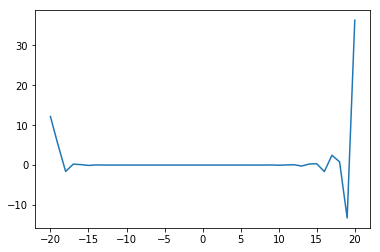

In [24]:
plt.plot(x,(fft(Mplusband_new)+fft(Mminousband_new)).real)

In [25]:
(fft(Mplusband_new)+fft(Mminousband_new))

array([ 1.21629336e+01+0.j,  5.07187522e+00+0.j, -1.61041996e+00+0.j,
        2.26932895e-01+0.j,  1.13009244e-01+0.j, -9.44683713e-02+0.j,
        2.76302502e-02+0.j,  4.87190629e-03+0.j, -8.87471174e-03+0.j,
        3.88231536e-03+0.j, -7.47196948e-05+0.j, -9.29783336e-04+0.j,
        5.67885846e-04+0.j, -9.55946160e-05+0.j, -9.26936889e-05+0.j,
        8.39298430e-05+0.j, -3.49000091e-05+0.j,  1.08276642e-05+0.j,
        6.25327233e-06+0.j, -5.34671445e-05+0.j,  1.16768237e-04+0.j,
       -8.57122730e-05+0.j, -1.91457398e-04+0.j,  6.68645380e-04+0.j,
       -7.71396173e-04+0.j, -5.39935219e-04+0.j,  3.58687613e-03+0.j,
       -5.69906800e-03+0.j,  2.49266217e-04+0.j,  1.80184462e-02+0.j,
       -3.85338639e-02+0.j,  2.14965494e-02+0.j,  8.31762163e-02+0.j,
       -2.49776305e-01+0.j,  2.50772572e-01+0.j,  3.31543622e-01+0.j,
       -1.63867767e+00+0.j,  2.46044571e+00+0.j,  8.07490389e-01+0.j,
       -1.32607027e+01+0.j,  3.63206530e+01+0.j])

In [26]:
circulant?